In [154]:
import numpy as np
from scipy.sparse import diags
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

Checking Power Iteration with 1D FV with 1D Analytical Solution

#### FVM Diffusion

In [134]:
def make_linear_system(h, D, siga, x0, xn, nu, sigf, phi):
    """For a 1d system with boundaries x0 and xn and mesh cells of size h, returns a finite volume linear system, Ax = b"""
    n = int((xn - x0)/h - 1)
    main_diag = 2*D/h**2 + siga
    off_diag = -D/h**2

    b = nu*sigf*phi 
    A = diags([off_diag, main_diag, off_diag], [-1, 0, 1], shape=(n, n)).toarray()
    
    return A, b

def make_rhs(nu, sigf, phi):
    return nu*sigf*phi 
    
def integrate_flux(f_new, h):
    return np.sum(f_new)*h

def solve_outer(h, D, siga, x0, xn, nu, sigf, phi):
    A, b = make_linear_system(h, D, siga, x0, xn, nu, sigf, phi)
    return np.linalg.solve(A, b)

Problem Set Up 

In [137]:
h = 0.
x0 = 0
xn = 1 # a
siga = 1
sigf = 1
D = 1/(3*(siga + sigf))
nu = 1

num_nodes = int((xn - x0)/h - 1)

Analytic Solution

$$ k = \frac{nu \Sigma_f }{\Sigma_a+ D \frac{\pi^2}{a^2}}$$

In [143]:
analytic_solution = nu*sigf/(siga + D*np.pi**2/xn**2)

In [148]:
def power_iteration(h, D, siga, x0, xn, nu, sigf, tol=1e-3):
    num_nodes = int((xn - x0)/h - 1)
    k = 1
    phi = np.ones(num_nodes)
    fiss_source = make_rhs(nu, sigf, phi) 
    int_fiss = integrate_flux(fiss_source, h)
    err = 1
    while err > tol:
        phi_new = solve_outer(h, D, siga, x0, xn, nu, sigf, 1/k*phi)
        fiss_source_new = make_rhs(nu, sigf, phi_new) 
        int_fiss_new = integrate_flux(fiss_source_new, h) # Integrate Fission Source
        k_new = k*(int_fiss_new/int_fiss)
        err_k = np.linalg.norm((k_new - k)/k_new)
        err_phi = np.linalg.norm((phi_new - phi)/phi_new)
        err = max(err_k, err_phi)
        int_fiss = np.copy(int_fiss_new)
        phi = np.copy(phi_new)
        k = np.copy(k_new)
    return k

Check Relative Error Between PI and Analytic Solution

Text(0.5,1,'Power Iteration Convergence Plot')

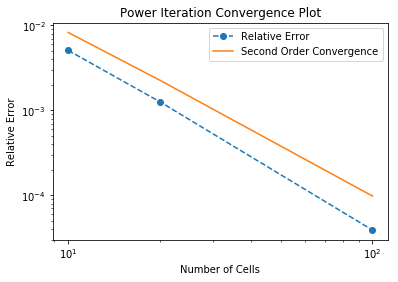

In [167]:
k = []
meshes = np.array([.1, 0.05, 0.01])
for h in meshes:
    k.append(power_iteration(h, D, siga, x0, xn, nu, sigf, tol=1e-3))
k = np.array(k)
rel_error = (k - analytic_solution)/k
cells = (xn - x0)/meshes
plt.loglog(cells, rel_error, linestyle="--", marker='o', label="Relative Error")
plt.loglog(cells, nodes**(-2), label="Second Order Convergence")
plt.legend()
plt.xlabel("Number of Cells")
plt.ylabel("Relative Error")
plt.title("Power Iteration Convergence Plot")

2D Finite Difference System

In [81]:
def make_linear_system_fd(h, D, siga, x0, xn, nu, sigf, phi):
    """For a 1d system with boundaries x0 and xn and mesh cells of size h, 
    returns a finite difference linear system, Ax = b"""
    n = int((xn - x0)/h - 1)
    main_diag = 4*D/h**2 + siga
    off_diag = -D/h**2
    
    # Make Block Diagonal
    a = diags([off_diag, main_diag, off_diag], [-1, 0, 1], shape=(n, n)).toarray()
    repeat = [a]*n
    A = block_diag(*repeat)
    
    # Add terms off diagonal
    A += diags([off_diag, off_diag], [-n, n], shape=(n**2, n**2)).toarray()
    
    b = nu*sigf*phi
    
    return A, b